# Meta-Labeling Experiments: A Step-by-Step Guide

## Introduction

This notebook recreates the meta-labeling experiments from Hudson & Thames' research in a beginner-friendly manner. Meta-labeling is a machine learning technique that sits on top of a primary trading strategy to improve performance by filtering out false positive signals.

**Key Concepts:**
- **Primary Model**: Generates trading signals (buy/sell/hold)
- **Triple Barrier Method**: Advanced labeling technique that accounts for stop-loss, take-profit, and time-based exits
- **Meta-Labeling**: Secondary ML model that decides whether to act on primary model signals
- **Goal**: Improve Sharpe ratio, reduce drawdown, and increase precision

## Setup and Dependencies

In [2]:
import sys
sys.path.append("..")  # Adjust based on your directory structure

%reload_ext autoreload
%load_ext line_profiler
%autoreload 3 -p

# %aimport afml

In [35]:
import warnings
import winsound
from datetime import timedelta, datetime as dt
from pprint import pprint
from pathlib import Path

import matplotlib.pyplot as plt
import MetaTrader5 as mt5
import seaborn as sns

from afml.data_structures.bars import *
from afml.filters import cusum_filter
from afml.labeling import (
    add_vertical_barrier,
    calculate_label_metrics,
    fixed_time_horizon,
    get_bins,
    get_bins_from_trend,
    get_events,
    triple_barrier_labels,
    get_trend_scanning_meta_labels,

)
from afml.strategies import (
    BaseStrategy,
    BollingerMeanReversionStrategy,
    MovingAverageCrossoverStrategy,
    TripleBarrierEvaluator,
    create_bollinger_features,
    get_entries,
)
from afml.util import (
    COMMODITIES,
    CLEAN_DATA_PATH,
    CRYPTO,
    DATA_PATH,
    FX_MAJORS,
    PERCENTILES,
    UTC,
    DataFrameFormatter,
    get_daily_vol,
    get_ticks,
    load_tick_data,
    login_mt5,
    save_data_to_parquet,
    value_counts_data,
    verify_or_create_account_info,
)

warnings.filterwarnings("ignore")
plt.style.use("dark_background")


In [7]:
from afml.cache import clear_afml_cache


clear_afml_cache()

## 1. Data Preparation

In [9]:
account = "FundedNext_STLR2_6K"
# account = login_mt5(account="FundedNext_STLR2_6K")
symbol = "EURUSD"
columns = ['bid', 'ask']
tick_bar_dict = {"M1": 50, "M5": 200, "M15": 700, "M30": 1000, "H1": 3000}
tick_df = None

start_date, end_date = "2018-01-01", "2024-12-31"
sample_start, sample_end = start_date, "2021-12-31"
oos_start = pd.Timestamp(sample_end) + timedelta(days=1) # Out-of-sample start date


def get_data(symbol, timeframe, dirpath="../data"):
    """Returns time-bars and tick-bars for timeframe"""
    global tick_df
    timeframe = timeframe.title()
    directory = Path(dirpath)
    tick_bar_size = tick_bar_dict[timeframe]
    fname = Path(dirpath, f"{symbol}_{timeframe}_time_{start_date}-{end_date}.parq")
    fname1 = Path(dirpath, f"{symbol}_{timeframe}_tick-{tick_bar_size}_{start_date}-{end_date}.parq")
    time_bars, tick_bars = (None, None)

    # --- Construct the search pattern ---
    # The '*' is a wildcard that matches any sequence of characters
    search_pattern = f"{symbol}_{timeframe}_*"

    # --- Find the files ---
    # glob() returns a generator, so you can iterate over it
    found_files = directory.glob(search_pattern)

    # --- Print the results ---
    for file in found_files:
        if fname == file:
            time_bars = pd.read_parquet(fname)
            print("Loaded", file.name)
        elif fname1 == file:
            tick_bars = pd.read_parquet(fname1)
            print("Loaded", file.name)
        
    if any(x is None for x in (time_bars, tick_bars)):
        try:
            tick_df = load_tick_data(CLEAN_DATA_PATH, symbol, start_date, end_date, account, columns)
        except FileNotFoundError:
            save_data_to_parquet(CLEAN_DATA_PATH, symbol, start_date, end_date, account)
        if time_bars is None:
            time_bars = make_bars(tick_df, bar_type="time", timeframe=timeframe, price="bid_ask", verbose=True)
            time_bars.to_parquet(fname)
        if tick_bars is None:
            tick_bar_size = calculate_ticks_per_period(tick_df, timeframe)
            tick_bar_dict[timeframe] = tick_bar_size
            tick_bars = make_bars(tick_df, bar_type="tick", bar_size=tick_bar_size, price="bid_ask", verbose=True)
            fname1 = Path(dirpath, f"{symbol}_{timeframe}_tick-{tick_bar_size}_{start_date}-{end_date}.parq")
            tick_bars.to_parquet(fname1)

    return time_bars, tick_bars

## 2. Bollinger Band Strategy

In [7]:
timeframe = "M5"
tick_bar_size = tick_bar_dict[timeframe]
bb_time_bars, bb_tick_bars = get_data(symbol, timeframe)
bar_size = f"tick-{bb_tick_bars.tick_volume.iloc[0]}"
bb_df = bb_time_bars.loc[sample_start : sample_end]
bb_df0 = bb_tick_bars.loc[sample_start : sample_end]

Loaded EURUSD_M5_tick-200_2018-01-01-2024-12-31.parq
Loaded EURUSD_M5_time_2018-01-01-2024-12-31.parq


### Feature Engineering

In [ ]:
bb_period, bb_std = 20, 1.5 # Bollinger Band parameters
bb_strategy = BollingerMeanReversionStrategy(window=bb_period, num_std=bb_std)

lookback = 10
bb_feat = create_bollinger_features(bb_df, lookback, bb_period, bb_std)
bb_feat["side"] = bb_strategy.generate_signals(bb_df)
bb_feat.info()

2025-08-29 22:26:49 | INFO     | 
Dropped features with correlation > 0.8: 
	['sma_diff_20_50', 'sma_diff_50_100', 'sma_diff_5_100']
Kept features: 
	['sma_diff_5_20', 'sma_diff_5_50', 'sma_diff_20_100']
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 295657 entries, 2018-01-01 23:05:00 to 2021-12-31 23:00:00
Data columns (total 51 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   rel_spread        295657 non-null  float32
 1   bb_bandwidth      295638 non-null  float32
 2   bb_percentage     295638 non-null  float64
 3   returns           295656 non-null  float32
 4   returns_5         295652 non-null  float32
 5   returns_10        295647 non-null  float32
 6   returns_1_lag_1   295655 non-null  float32
 7   returns_5_lag_1   295647 non-null  float32
 8   returns_10_lag_1  295637 non-null  float32
 9   returns_1_lag_2   295654 non-null  float32
 10  returns_5_lag_2   295642 non-null  float32
 11  returns_10_lag_2  2956

In [46]:
target_vol_params = dict(days=1, lookback=100)
tb_evaluator = TripleBarrierEvaluator(
    bb_strategy, bb_df, target_vol_params,
    target_vol_multiplier=1,
    filter_events=True,
    vertical_barrier_zero=True,
    on_crossover=True,
    )
pt_barrier, sl_barrier, time_horizon = (2, 1, 20)

2025-08-29 22:04:26.490 | INFO     | afml.strategies.genetic_optimizer:__init__:147 - Generating primary signals...
2025-08-29 22:04:26.737 | INFO     | afml.strategies.strategies:get_entries:76 - Generated 7,834 trade events generated by CUSUM filter.


### Fixed-Time Horizon Method

In [83]:
bb_events_fh = tb_evaluator.evaluate_performance(0, 0, time_horizon)
bb_events_fh_metrics = tb_evaluator.calculate_strategy_metrics(bb_events_fh)

### Triple-Barrier Method

In [84]:
bb_events_tbl = tb_evaluator.evaluate_performance(pt_barrier, sl_barrier, time_horizon)
bb_events_tbl_metrics = tb_evaluator.calculate_strategy_metrics(bb_events_tbl)

In [85]:
print(f"Bollinger_w{bb_period}_std{bb_std}: \n")

bb_metrics_df = pd.DataFrame({
    "fixed_horizon": bb_events_fh_metrics,
    "triple_barrier": bb_events_tbl_metrics,
    })
bb_metrics_df

Bollinger_w20_std1.5: 



,fixed_horizon,triple_barrier
total_return,0.724101,0.442506
annualized_return,0.146205,0.096128
volatility,0.405758,0.377989
downside_volatility,0.275666,0.227723
sharpe_ratio,12.887154,9.347379
sortino_ratio,18.968848,15.515375
var_95,-0.002226,-0.002
cvar_95,-0.003281,-0.002784
skewness,0.337767,0.426003
kurtosis,4.533642,3.02738


### Trend-Scanning Method

In [ ]:
from afml.filters.filters import cusum_filter
from afml.labeling.trend_scanning import get_trend_scanning_meta_labels
from afml.util.volatility import get_daily_vol


span = (5, 21)
volatility_threshold = 0.1
volatility_threshold_mr = 0.85

thres = get_daily_vol(bb_df.close).mean()
t_events = cusum_filter(bb_df.close, thres)
side = bb_strategy.generate_signals(bb_df)
close = bb_df.close


bb_events_trend = get_trend_scanning_meta_labels(close, side, t_events, span, volatility_threshold)
bb_events_trend_metrics = calculate_label_metrics(bb_df.index, side, bb_events_trend)

# bb_events_trend_mr = get_bins_from_trend(close, span, volatility_threshold_mr)
# bb_events_trend_mr = trend_meta_labels(bb_events_trend_mr, side, t_events, mean_reversion=True)
bb_events_trend_mr = get_trend_scanning_meta_labels(close, side, t_events, span, volatility_threshold_mr)
bb_events_trend_metrics_mr = calculate_label_metrics(bb_df.index, side, bb_events_trend_mr)

print(f"bb_events_trend.shape: {bb_events_trend.shape}, bb_events_trend_mr.shape: {bb_events_trend_mr.shape}\n")
print(f"Bollinger_w{bb_period}_std{bb_std}_trend_scanning: \n")
bb_events_trend_metrics_all = pd.concat([bb_events_trend_metrics, bb_events_trend_metrics_mr], axis=1)
bb_events_trend_metrics_all.columns = ["trend_time", "trend_time_mr"]
bb_events_trend_metrics_all

bb_events_trend.shape: (9708, 4), bb_events_trend_mr.shape: (9708, 4)

Bollinger_w20_std1.5_trend_scanning: 



,trend_time,trend_time_mr
total_return,0.989336,0.464981
annualized_return,0.187899,0.100309
volatility,0.390722,0.295388
downside_volatility,0.283881,0.263371
sharpe_ratio,13.607675,9.996627
sortino_ratio,18.729055,11.211856
var_95,-0.00222,-0.001544
cvar_95,-0.003258,-0.002692
skewness,0.156996,0.395475
kurtosis,5.306702,14.829727


### Random Forest

In [38]:
from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from collections import namedtuple

from afml.cross_validation.cross_validation import PurgedSplit
from afml.backtest_statistics.reporting import (
    create_classification_report_image,
    meta_labelling_reports,
)


random_state = 40
min_w_leaf = 0.05

rf = RandomForestClassifier(
    criterion='entropy',
    n_estimators=1000,
    class_weight='balanced_subsample',
    random_state=random_state,
    min_weight_fraction_leaf=min_w_leaf,
    n_jobs=-1,  # Use all available cores
    )

def train_meta_model(model, features, labels, test_size=0.3) -> namedtuple:
    """
    Generate meta-labeling report for both tick and time bar features.

    Args:
        model_template: Classifier to be used for meta-labeling.
        X: DataFrame containing features.
        cont: DataFrame containing label features.

    Returns: namedtuple that contains fit, X_train, X_test, y_train, y_test, w_train, w_test, pred, prob
    """

    # Prepare features and target
    X = features.replace([np.inf, -np.inf], np.nan).dropna()
    cont = labels.loc[X.index]
    y = cont["bin"]
    w = cont["w"] if "w" in cont else np.ones_like(y)  # sample weights
    t1 = cont["t1"]

    # Split data
    train, test = PurgedSplit(t1, test_size).split(X)
    X_train, X_test, y_train, y_test, w_train, w_test = (
        X.iloc[train],
        X.iloc[test],
        y.iloc[train],
        y.iloc[test],
        w[train],
        w[test],
    )

    if isinstance(model, BaggingClassifier):
        # Set max_samples based on average uniqueness from the triple barrier
        try:
            av_uniqueness = cont["tW"].iloc[train].mean()
            print(f"Average uniqueness: {av_uniqueness:.4f}")
            model.set_params(max_samples=av_uniqueness)
        except KeyError:
            model = clone(model)
            print("Warning: 'tW' column not found in labels. Using default max_samples.\n")
    else:
        model = clone(model)  # Ensure independence of estimator instances

    model.fit(X_train, y_train, sample_weight=w_train)

    # Make predictions
    pred = model.predict(X_test)
    prob = model.predict_proba(X_test)[:, 1]
    pred = pd.Series(pred, index=X_test.index, name="pred")
    prob = pd.Series(prob, index=X_test.index, name="prob")

    model_data = namedtuple(
        "ModelData", ["fit", "X_train", "X_test", "y_train", "y_test", "w_train", "w_test", "pred", "prob"]
    )
    return model_data(model, X_train, X_test, y_train, y_test, w_train, w_test, pred, prob)

In [115]:
from typing import List

from sklearn.metrics import roc_auc_score, roc_curve


def compare_roc_curves(
    model_data: List[namedtuple], titles: List[str] = None
):
    n = len(model_data)
    fig, axes = plt.subplots(nrows=n // 2, ncols=2, sharex=True, sharey=True, figsize=(7.5, 5), dpi=100)
    axes = axes.flatten()
    if not titles:
        titles = [""] * n

    # Plot ROC curve
    for data, ax, title in zip(model_data, axes, titles):
        # Compute ROC curve
        fpr, tpr, _ = roc_curve(data.y_test, data.prob, sample_weight=data.w_test)
        auc = roc_auc_score(data.y_test, data.prob, sample_weight=data.w_test)
        ax.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.2f})", color="blue")
        ax.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Chance")
        ax.set_xlabel("False Positive Rate")
        ax.set_ylabel("True Positive Rate")
        ax.set_title(f"{title}")
        ax.legend()
    
    plt.tight_layout()
    plt.style.use("dark_background")
    return fig


def meta_labelling_classification_reports(model_data, title, output_filename):
    create_classification_report_image(
        y_true=model_data.y_test, 
        y_pred=np.ones_like(model_data.pred), 
        title=f"{title} Primary Model", 
        output_filename=f"{output_filename}_primary_clf_report.png",
        display=False,
        )
    create_classification_report_image(
        y_true=model_data.y_test, 
        y_pred=model_data.pred, 
        title=f"{title} Meta-Model", 
        output_filename=f"{output_filename}_meta_clf_report.png",
        display=False,
        )
    print("Classification reports saved.\n")

Fixed-Time Horizon Meta-Model Results:

Primary-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1146
           1       0.51      1.00      0.68      1201

    accuracy                           0.51      2347
   macro avg       0.26      0.50      0.34      2347
weighted avg       0.26      0.51      0.35      2347


Confusion Matrix:
[[   0 1146]
 [   0 1201]]

Meta-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.48      0.59      0.53      1146
           1       0.49      0.38      0.43      1201

    accuracy                           0.48      2347
   macro avg       0.48      0.49      0.48      2347
weighted avg       0.49      0.48      0.48      2347


Confusion Matrix:
[[677 469]
 [744 457]]


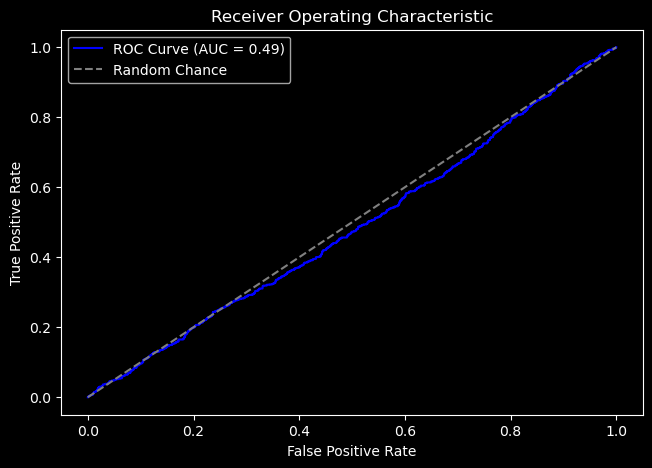

In [87]:
model_bb_fh = train_meta_model(model=rf, features=bb_feat.reindex(bb_events_fh.index), labels=bb_events_fh)
print("Fixed-Time Horizon Meta-Model Results:\n")
meta_labelling_reports(
    model_bb_fh.y_test, model_bb_fh.w_test, model_bb_fh.pred, model_bb_fh.prob, plot_roc=True
    )

Triple Barrier Meta-Model Results:

Primary-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2186
           1       0.07      1.00      0.13       161

    accuracy                           0.07      2347
   macro avg       0.03      0.50      0.06      2347
weighted avg       0.00      0.07      0.01      2347


Confusion Matrix:
[[   0 2186]
 [   0  161]]

Meta-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.97      0.71      0.82      2186
           1       0.15      0.68      0.24       161

    accuracy                           0.71      2347
   macro avg       0.56      0.70      0.53      2347
weighted avg       0.91      0.71      0.78      2347


Confusion Matrix:
[[1557  629]
 [  51  110]]


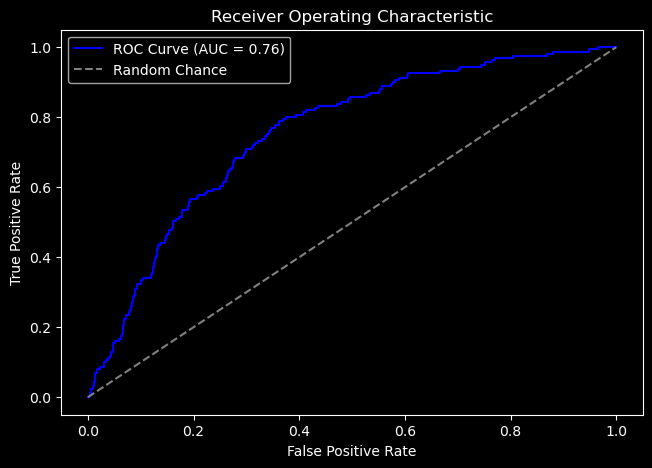

In [88]:
model_bb_tbl = train_meta_model(model=rf, features=bb_feat.reindex(bb_events_tbl.index), labels=bb_events_tbl)
print("Triple Barrier Meta-Model Results:\n")
meta_labelling_reports(
    model_bb_tbl.y_test, model_bb_tbl.w_test, model_bb_tbl.pred, model_bb_tbl.prob, plot_roc=True
    )

Trend-Scanning Meta-Model Results:

Primary-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1584
           1       0.46      1.00      0.63      1325

    accuracy                           0.46      2909
   macro avg       0.23      0.50      0.31      2909
weighted avg       0.21      0.46      0.29      2909


Confusion Matrix:
[[   0 1584]
 [   0 1325]]

Meta-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.85      0.32      0.47      1584
           1       0.54      0.93      0.68      1325

    accuracy                           0.60      2909
   macro avg       0.69      0.63      0.58      2909
weighted avg       0.71      0.60      0.57      2909


Confusion Matrix:
[[ 513 1071]
 [  88 1237]]


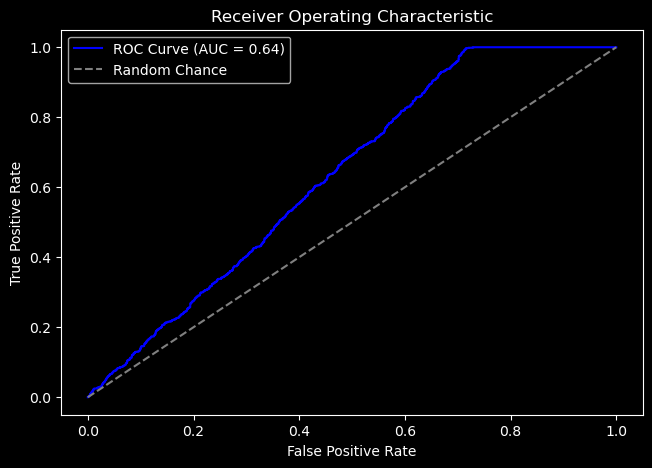

In [116]:
model_bb_trend = train_meta_model(model=rf, features=bb_feat.reindex(bb_events_trend.index), labels=bb_events_trend)
print("Trend-Scanning Meta-Model Results:\n")
meta_labelling_reports(
    model_bb_trend.y_test, model_bb_trend.w_test, model_bb_trend.pred, model_bb_trend.prob, plot_roc=True
    )

Trend-Scanning Mean-Reversion Meta-Model Results:

Primary-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2688
           1       0.08      1.00      0.14       221

    accuracy                           0.08      2909
   macro avg       0.04      0.50      0.07      2909
weighted avg       0.01      0.08      0.01      2909


Confusion Matrix:
[[   0 2688]
 [   0  221]]

Meta-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.99      0.91      0.95      2688
           1       0.47      0.94      0.63       221

    accuracy                           0.92      2909
   macro avg       0.73      0.93      0.79      2909
weighted avg       0.95      0.92      0.93      2909


Confusion Matrix:
[[2457  231]
 [  14  207]]


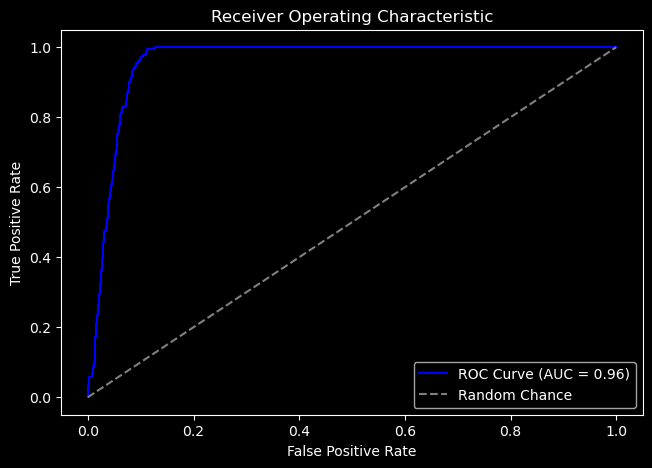

In [100]:
model_bb_trend_mr = train_meta_model(model=rf, features=bb_feat.reindex(bb_events_trend_mr.index), labels=bb_events_trend_mr)
print("Trend-Scanning Mean-Reversion Meta-Model Results:\n")
meta_labelling_reports(
    model_bb_trend_mr.y_test, model_bb_trend_mr.w_test, model_bb_trend_mr.pred, model_bb_trend_mr.prob, plot_roc=True
    )

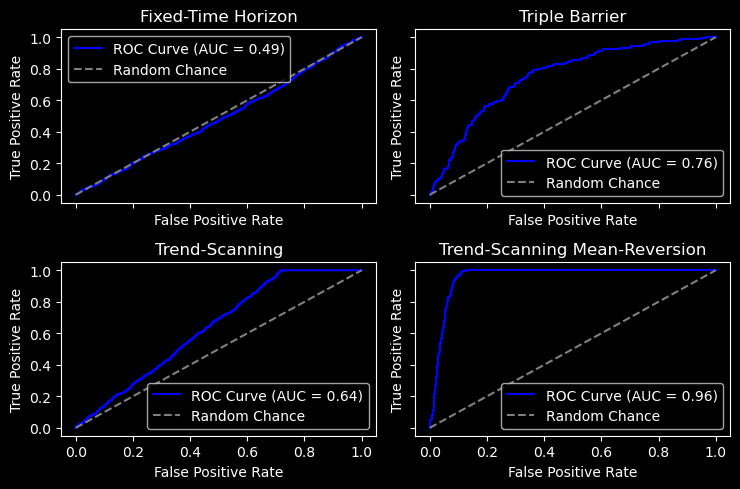

In [ ]:
titles = ["Fixed-Time Horizon", "Triple Barrier", "Trend-Scanning", "Trend-Scanning Mean-Reversion"]
bb_models = [model_bb_fh, model_bb_tbl, model_bb_trend, model_bb_trend_mr]
bb_roc = compare_roc_curves(bb_models, titles)
bb_roc.savefig("reports/bollinger_roc_comparison.png")

In [ ]:
meta_labelling_classification_reports(model_data=model_bb_fh, title="Fixed-Time Horizon", output_filename="bb_fixed_time")
meta_labelling_classification_reports(model_data=model_bb_fh, title="Triple Barrier", output_filename="bb_triple_barrier")
meta_labelling_classification_reports(model_data=model_bb_fh, title="Trend-Scanning", output_filename="bb_trend_scanning")
meta_labelling_classification_reports(model_data=model_bb_fh, title="Trend-Scanning (Mean-Reversion)", output_filename="bb_trend_scanning_mr")

Classification Report (as text):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1146
           1       0.51      1.00      0.68      1201

    accuracy                           0.51      2347
   macro avg       0.26      0.50      0.34      2347
weighted avg       0.26      0.51      0.35      2347


Confusion Matrix:
[[   0 1146]
 [   0 1201]]

Accuracy:
0.5117170856412442

Successfully generated and saved 'fixed_time_primary_clf_report.png'
Classification Report (as text):
              precision    recall  f1-score   support

           0       0.48      0.59      0.53      1146
           1       0.49      0.38      0.43      1201

    accuracy                           0.48      2347
   macro avg       0.48      0.49      0.48      2347
weighted avg       0.49      0.48      0.48      2347


Confusion Matrix:
[[677 469]
 [744 457]]

Accuracy:
0.4831700042607584

Successfully generated and saved 'fixed_time_meta_clf_report.

## 3. Moving Average Crossover Strategy

In [ ]:
timeframe = "M30"
tick_bar_size = tick_bar_dict[timeframe]
ma_time_bars, ma_tick_bars = get_data(symbol, timeframe)
bar_size = f"tick-{ma_tick_bars.tick_volume.iloc[0]}"
ma_df = ma_time_bars.loc[sample_start : sample_end]
ma_df0 = ma_tick_bars.loc[sample_start : sample_end]

fast_window, slow_window = 20, 50
ma_strategy = MovingAverageCrossoverStrategy(fast_window, slow_window)
target_vol_params = dict(days=1, lookback=100)
vol_multiplier = 0.5
pt_barrier, sl_barrier, time_horizon = (3, 1, 200)
tb_evaluator = TripleBarrierEvaluator(
    ma_strategy, ma_df, target_vol_params,
    target_vol_multiplier=vol_multiplier,
    filter_events=True,
    vertical_barrier_zero=False,
    )

Loaded EURUSD_M30_tick-1000_2018-01-01-2024-12-31.parq
Loaded EURUSD_M30_time_2018-01-01-2024-12-31.parq
2025-08-30 06:06:25.017 | INFO     | afml.strategies.genetic_optimizer:__init__:147 - Generating primary signals...
2025-08-30 06:06:25.081 | INFO     | afml.strategies.strategies:get_entries:76 - Generated 5,988 trade events generated by CUSUM filter.


### Feature Engineering

In [177]:
from afml.strategies.ma_crossover_feature_engine import ForexFeatureEngine

# ma_feat = create_bollinger_features(ma_df, lookback_window=fast_window, bb_period=20, bb_std=2)
# trend_feat = get_bins_from_trend(ma_df.close, span=(5, time_horizon), volatility_threshold=0.1, lookforward=False)
# trend_feat_cols = ['window', 't_value', 'rsquared']
# trend_feat.rename(columns={k: f"trend_{k}" for k in trend_feat_cols}, inplace=True)
# ma_feat = ma_feat.join(trend_feat[[f"trend_{k}" for k in trend_feat_cols]])

feat_engine = ForexFeatureEngine(pair_name=symbol)
ma_feat = feat_engine.calculate_all_features(ma_df)

ma_feat["side"] = ma_strategy.generate_signals(ma_df)
ma_feat.info()

Memory usage reduced from 5.71 MB to 3.83 MB (32.9% reduction)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49280 entries, 2018-01-01 23:30:00 to 2021-12-31 23:00:00
Data columns (total 83 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ma_10                           49280 non-null  float64
 1   ma_20                           49280 non-null  float64
 2   ma_50                           49280 non-null  float64
 3   ma_100                          49280 non-null  float64
 4   ma_200                          49280 non-null  float64
 5   ma_10_20_cross                  49280 non-null  int32  
 6   ma_20_50_cross                  49280 non-null  int32  
 7   ma_50_200_cross                 49280 non-null  int32  
 8   ma_spread_10_20                 49280 non-null  float64
 9   ma_spread_20_50                 49280 non-null  float64
 10  ma_spread_50_200                49280 non-null  float64


### Fixed-Time Horizon Method

In [178]:
ma_events_fh = tb_evaluator.evaluate_performance(0, 0, time_horizon)
ma_events_fh_metrics = tb_evaluator.calculate_strategy_metrics(ma_events_fh)
ma_events_fh_metrics

total_return                           0.898958
annualized_return                      0.174281
volatility                              1.10215
downside_volatility                    0.720549
sharpe_ratio                           1.753298
sortino_ratio                          2.681839
var_95                                -0.015042
cvar_95                               -0.021589
skewness                               0.005453
kurtosis                               2.034684
probabilistic_sharpe_ratio             0.888705
pos_concentration                      0.000265
neg_concentration                      0.000262
time_concentration                     0.003805
max_drawdown                           0.630101
avg_drawdown                           0.310787
drawdown_duration             111 days 21:30:00
ulcer_index                            0.388294
calmar_ratio                           0.276592
num_trades                                 5965
trades_per_year                         

### Triple-Barrier Method

In [179]:
ma_events_tbl = tb_evaluator.evaluate_performance(pt_barrier, sl_barrier, time_horizon)
ma_events_tbl_metrics = tb_evaluator.calculate_strategy_metrics(ma_events_tbl)
ma_events_tbl_metrics

total_return                          1.198094
annualized_return                     0.218113
volatility                            0.417609
downside_volatility                   0.112141
sharpe_ratio                          4.091394
sortino_ratio                        15.236145
var_95                               -0.003732
cvar_95                              -0.004668
skewness                              1.191128
kurtosis                              0.780038
probabilistic_sharpe_ratio            0.998227
pos_concentration                     0.000122
neg_concentration                     0.000056
time_concentration                    0.003776
max_drawdown                          0.304603
avg_drawdown                          0.035849
drawdown_duration             22 days 10:25:51
ulcer_index                           0.071087
calmar_ratio                          0.716055
num_trades                                5986
trades_per_year                           1498
win_rate     

In [180]:
print(f"MACrossover_fast{fast_window}_slow{slow_window}: \n")

ma_metrics_df = pd.DataFrame({
    "fixed_horizon": ma_events_fh_metrics,
    "triple_barrier": ma_events_tbl_metrics,
    })
ma_metrics_df

MACrossover_fast20_slow50: 



,fixed_horizon,triple_barrier
total_return,0.898958,1.198094
annualized_return,0.174281,0.218113
volatility,1.10215,0.417609
downside_volatility,0.720549,0.112141
sharpe_ratio,1.753298,4.091394
sortino_ratio,2.681839,15.236145
var_95,-0.015042,-0.003732
cvar_95,-0.021589,-0.004668
skewness,0.005453,1.191128
kurtosis,2.034684,0.780038


### Trend-Scanning Method

In [181]:
span = (5, time_horizon)
volatility_threshold = 0.1

thres = get_daily_vol(ma_df.close).mean() * vol_multiplier
t_events = cusum_filter(ma_df.close, thres)
print(f"t_events: {len(t_events):,}")

side = ma_strategy.generate_signals(ma_df)
close = ma_df.close

ma_events_trend = get_trend_scanning_meta_labels(close, side, t_events, span, volatility_threshold)
ma_events_trend_metrics = calculate_label_metrics(ma_df.index, side, ma_events_trend)

ma_metrics_df = pd.DataFrame({
    "fixed_horizon": ma_events_fh_metrics,
    "triple_barrier": ma_events_tbl_metrics,
    "trend_scanning": ma_events_trend_metrics,
    })

print(f"MACrossover_fast{fast_window}_slow{slow_window}:")
print(f"ma_events_trend.shape: {ma_events_trend.shape}\n")
ma_metrics_df

t_events: 5,993
2025-08-30 06:07:04.192 | INFO     | afml.labeling.performance_metrics:calculate_label_metrics:41 - Calculating avg_trade_duration using (events['t1'] - events.index).mean()
MACrossover_fast20_slow50:
ma_events_trend.shape: (5970, 4)



,fixed_horizon,triple_barrier,trend_scanning
total_return,0.898958,1.198094,3.986432
annualized_return,0.174281,0.218113,0.495156
volatility,1.10215,0.417609,1.156369
downside_volatility,0.720549,0.112141,0.724708
sharpe_ratio,1.753298,4.091394,3.447821
sortino_ratio,2.681839,15.236145,5.501458
var_95,-0.015042,-0.003732,-0.015248
cvar_95,-0.021589,-0.004668,-0.022259
skewness,0.005453,1.191128,-0.026077
kurtosis,2.034684,0.780038,1.466651


### Random Forest

Fixed-Time Horizon Meta-Model Results:

Primary-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       878
           1       0.51      1.00      0.67       911

    accuracy                           0.51      1789
   macro avg       0.25      0.50      0.34      1789
weighted avg       0.26      0.51      0.34      1789


Confusion Matrix:
[[  0 878]
 [  0 911]]

Meta-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.51      0.67      0.58       878
           1       0.55      0.38      0.45       911

    accuracy                           0.52      1789
   macro avg       0.53      0.53      0.51      1789
weighted avg       0.53      0.52      0.51      1789


Confusion Matrix:
[[587 291]
 [562 349]]


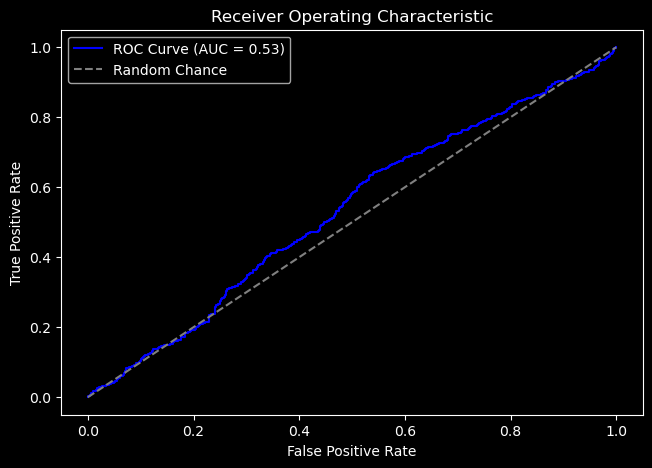

In [182]:
model_ma_fh = train_meta_model(model=rf, features=ma_feat.reindex(ma_events_fh.index), labels=ma_events_fh)
print("Fixed-Time Horizon Meta-Model Results:\n")
meta_labelling_reports(
    model_ma_fh.y_test, model_ma_fh.w_test, model_ma_fh.pred, model_ma_fh.prob, plot_roc=True
    )

Triple Barrier Meta-Model Results:

Primary-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1287
           1       0.28      1.00      0.44       508

    accuracy                           0.28      1795
   macro avg       0.14      0.50      0.22      1795
weighted avg       0.08      0.28      0.12      1795


Confusion Matrix:
[[   0 1287]
 [   0  508]]

Meta-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.72      0.98      0.83      1287
           1       0.38      0.03      0.05       508

    accuracy                           0.71      1795
   macro avg       0.55      0.50      0.44      1795
weighted avg       0.62      0.71      0.61      1795


Confusion Matrix:
[[1264   23]
 [ 494   14]]


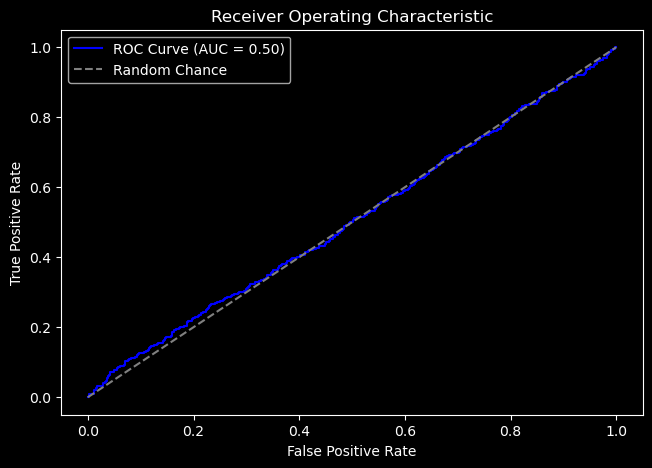

In [183]:
model_ma_tbl = train_meta_model(model=rf, features=ma_feat.reindex(ma_events_tbl.index), labels=ma_events_tbl)
print("Triple Barrier Meta-Model Results:\n")
meta_labelling_reports(
    model_ma_tbl.y_test, model_ma_tbl.w_test, model_ma_tbl.pred, model_ma_tbl.prob, plot_roc=True
    )

Trend-Scanning Meta-Model Results:

Primary-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       981
           1       0.45      1.00      0.62       809

    accuracy                           0.45      1790
   macro avg       0.23      0.50      0.31      1790
weighted avg       0.20      0.45      0.28      1790


Confusion Matrix:
[[  0 981]
 [  0 809]]

Meta-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.57      0.80      0.67       981
           1       0.53      0.28      0.37       809

    accuracy                           0.56      1790
   macro avg       0.55      0.54      0.52      1790
weighted avg       0.56      0.56      0.53      1790


Confusion Matrix:
[[783 198]
 [583 226]]


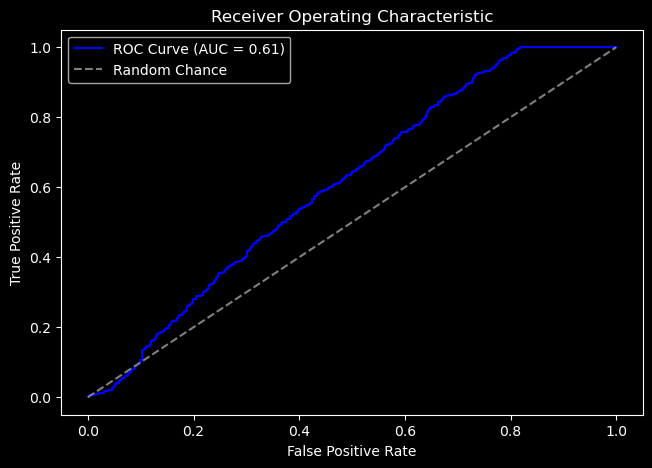

In [184]:
model_ma_trend = train_meta_model(model=rf, features=ma_feat.reindex(ma_events_trend.index), labels=ma_events_trend)
print("Trend-Scanning Meta-Model Results:\n")
meta_labelling_reports(
    model_ma_trend.y_test, model_ma_trend.w_test, model_ma_trend.pred, model_ma_trend.prob, plot_roc=True
    )

In [185]:
dirpath = "reports"
meta_labelling_classification_reports(model_data=model_ma_fh, title="Fixed-Time Horizon", output_filename=f"{dirpath}/ma_fixed_time")
meta_labelling_classification_reports(model_data=model_ma_fh, title="Triple Barrier", output_filename=f"{dirpath}/ma_triple_barrier")
meta_labelling_classification_reports(model_data=model_ma_fh, title="Trend-Scanning", output_filename=f"{dirpath}/ma_trend_scanning")
meta_labelling_classification_reports(model_data=model_ma_fh, title="Trend-Scanning (Mean-Reversion)", output_filename=f"{dirpath}/ma_trend_scanning_mr")

Classification Report (as text):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       878
           1       0.51      1.00      0.67       911

    accuracy                           0.51      1789
   macro avg       0.25      0.50      0.34      1789
weighted avg       0.26      0.51      0.34      1789


Confusion Matrix:
[[  0 878]
 [  0 911]]

Accuracy:
0.5092230296254892

Successfully generated and saved 'reports/ma_fixed_time_primary_clf_report.png'
Classification Report (as text):
              precision    recall  f1-score   support

           0       0.51      0.67      0.58       878
           1       0.55      0.38      0.45       911

    accuracy                           0.52      1789
   macro avg       0.53      0.53      0.51      1789
weighted avg       0.53      0.52      0.51      1789


Confusion Matrix:
[[587 291]
 [562 349]]

Accuracy:
0.5231973169368362

Successfully generated and saved 'reports/ma_fixed_tim